In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [7]:
data = r"C:\Users\garde\Desktop\Github\data\wines_properties.csv"
df = pd.read_csv(data, engine = "python", sep = ',')
df.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline,Customer_Segment
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1


# Standardisation

In [8]:
df_s = StandardScaler().fit_transform(df)

# Getting eigenvalues & eigenvectors

In [9]:
covariance_matrix = np.cov(df_s.T)
eigen_values, eigen_vectors = np.linalg.eig(covariance_matrix)

# Choosing the number of components

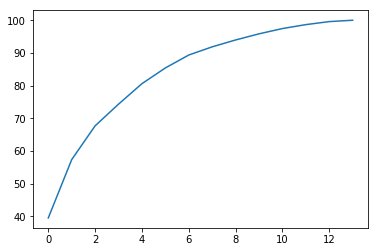

In [10]:
tot_eig_vals = sum(eigen_values)
sorted_eigenvalues = sorted(eigen_values, reverse=True)
variance_explained = [ (i / tot_eig_vals)*100 for i in sorted_eigenvalues ]
np.cumsum(variance_explained)
plt.plot(np.cumsum(variance_explained))

# Projecting original data in a new space

In [11]:
eigen_vectors_values = [ ( np.abs(eigen_values[i]), eigen_vectors[:, i] )
                        for i in range(len(eigen_values)) ]
eigen_vectors_values.sort()
eigen_vectors_values.reverse()

top2_eigenvectors = np.hstack( (eigen_vectors_values[0][1].reshape(14, -1),
                                eigen_vectors_values[1][1].reshape(14, -1)
                                ) )
Y = df_s.dot(top2_eigenvectors)

# Circle of Correlation

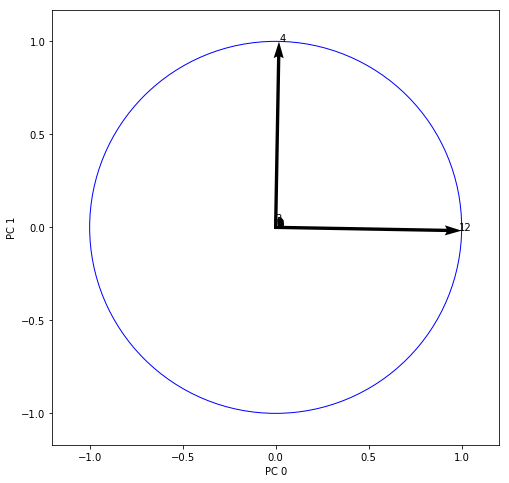

In [12]:
pca = PCA().fit(df)

# Get the PCA components (loadings)
PCs = pca.components_

# Use quiver to generate the basic plot
fig = plt.figure(figsize=(8,8))
plt.quiver(np.zeros(PCs.shape[1]), np.zeros(PCs.shape[1]),
           PCs[0,:], PCs[1,:], 
           angles='xy', scale_units='xy', scale=1)

# Add labels based on feature names (here just numbers)
feature_names = np.arange(PCs.shape[1])
for i,j,z in zip(PCs[1,:]+0.02, PCs[0,:]+0.02, feature_names):
    plt.text(j, i, z, ha='center', va='center')

# Add unit circle
circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
plt.gca().add_artist(circle)

# Ensure correct aspect ratio and axis limits
plt.axis('equal')
plt.xlim([-1.2,1.2])
plt.ylim([-1.2,1.2])

# Label axes
plt.xlabel('PC 0')
plt.ylabel('PC 1')

# Done
plt.show()

# Hierarchical Cluster Algorithm

In [13]:
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage

row_dist = pd.DataFrame(squareform(pdist(df, metric='euclidean')))

row_clusters = linkage(pdist(df, metric='euclidean'), method='complete')

pd.DataFrame(row_clusters,
             columns=['row label 1', 'row label 2',
                      'distance', 'no. of items in clust.'],
             index=['cluster %d' % (i + 1) 
                    for i in range(row_clusters.shape[0])]).head()

,row label 1,row label 2,distance,no. of items in clust.
cluster 1,160.0,165.0,2.610709,2.0
cluster 2,67.0,106.0,2.654713,2.0
cluster 3,13.0,50.0,2.949610,2.0
cluster 4,8.0,9.0,3.270076,2.0
cluster 5,101.0,119.0,3.479253,2.0


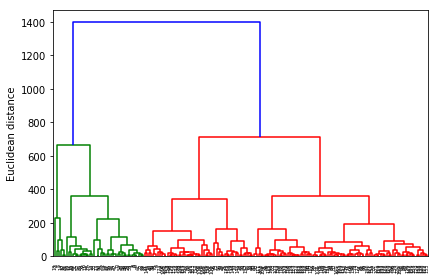

In [14]:
from scipy.cluster.hierarchy import dendrogram

row_dendr = dendrogram(row_clusters)
plt.tight_layout()
plt.ylabel('Euclidean distance')

plt.show()

# K-means cluster analysis

In [15]:
from sklearn.cluster import KMeans

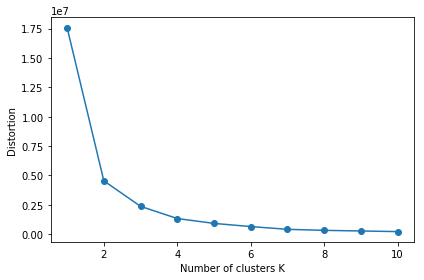

In [16]:
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, 
                init='k-means++', 
                n_init=10, 
                max_iter=300, 
                random_state=0)
    km.fit(df)
    distortions.append(km.inertia_)
    
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters K')
plt.ylabel('Distortion')
plt.tight_layout()
plt.show()

In [17]:
# elbow point seems to be at K = 2

# Silhouette Analysis

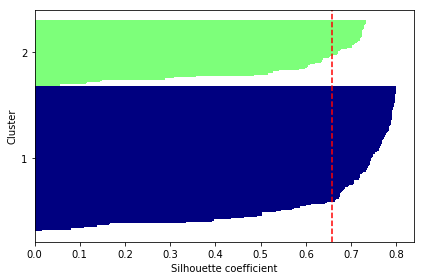

In [18]:
from matplotlib import cm
from sklearn.metrics import silhouette_samples
from sklearn.metrics import silhouette_score

km = KMeans(n_clusters=2, 
            init='k-means++', 
            n_init=10, 
            max_iter=300,
            tol=1e-04,
            random_state=0)
y_km = km.fit_predict(df)

cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]

silhouette_vals = silhouette_samples(df, y_km, metric='euclidean')

y_ax_lower, y_ax_upper = 0, 0
yticks = []

for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
             edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--") 

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')

plt.tight_layout()
plt.show()


# Plotting in PCA

In [19]:
km = KMeans(n_clusters=2, 
            init='random', 
            n_init=10, 
            max_iter=300,
            tol=1e-04,
            random_state=0)

y_km = km.fit_predict(df)

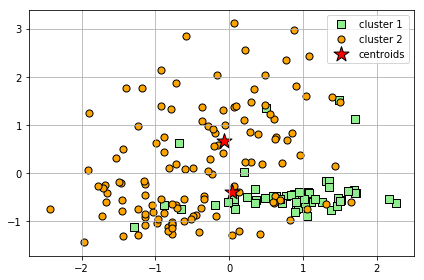

In [20]:
# cluster 1
plt.scatter(df_s[y_km == 0, 0],
            df_s[y_km == 0, 1],
            s=50, c='lightgreen',
            marker='s', edgecolor='black',
            label='cluster 1')
# cluster 2
plt.scatter(df_s[y_km == 1, 0],
            df_s[y_km == 1, 1],
            s=50, c='orange',
            marker='o', edgecolor='black',
            label='cluster 2')

# centroids 
y_km = km.fit_predict(df_s)

plt.scatter(km.cluster_centers_[:, 0],
            km.cluster_centers_[:, 1],
            s=250, marker='*',
            c='red', edgecolor='black',
            label='centroids')

plt.legend(scatterpoints=1)
plt.grid()
plt.tight_layout()
plt.show()

# K-means function

In [21]:
def AutoKm(data):
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler
    import seaborn as sns
    import numpy as np
    import pandas as pd
    from sklearn.cluster import KMeans
    import matplotlib.pyplot as plt
    %matplotlib inline
    from matplotlib import cm
    from sklearn.metrics import silhouette_samples
    
#    #finding the number K (ELBOW POINT METHOD)
#    distortions = []
#    dist_count = []
#    y = 0
    
#    for i in range(1, 11):
#        km = KMeans(n_clusters=i, 
#                    init='k-means++', 
#                    n_init=10, 
#                    max_iter=300, 
#                    random_state=0)
#        km.fit(data)
#        distortions.append(km.inertia_)
        
#    for i in range(len(distortions) - 1):
#        j = i + 1
#        d = abs(distortions[i] - distortions[j])
#        dist_count.append(d)
   
#    max_d = max(dist_count)
#    K = dist_count.index(max_d) + 2   #at elbow point

# score k means
#XXX add silhouette score to find best K cluster number 
    
    #plotting
    colors = ["lightgreen", "orange", "banana", "blue", "blueviolet"]
    markers = ["o", "v", "^", "h", ">", "s"]
    
    km = KMeans(n_clusters=K, 
            init='random', 
            n_init=10, 
            max_iter=300,
            tol=1e-04,
            random_state=0)

    y_km = km.fit_predict(data)
    
    data_s = StandardScaler().fit_transform(data)
    
    #clusters
    for i in range(K):
        plt.scatter(data_s[y_km == i, 0],
                    df_s[y_km == i, 1],
                    s=50, c=colors[i],
                    marker=markers[i], edgecolor='black',
                    label='cluster ' + str(i) )
    
    #centroid
    y_km = km.fit_predict(data_s)

    plt.scatter(km.cluster_centers_[:, 0],
                km.cluster_centers_[:, 1],
                s=250, marker='*',
                c='red', edgecolor='black',
                label='centroids')

    plt.legend(scatterpoints=1)
    plt.grid()
    plt.tight_layout()
    
    return "Value of K is " + str(K)

In [22]:
AutoKm(df)

NameError: name 'K' is not defined

# PCA function

In [24]:
def AutoPCA(data):
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    %matplotlib inline
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler
    import seaborn as sns
    
    #standardisation
    data_s = StandardScaler().fit_transform(data)
    
    #eigenvalues and eigenvectors
    covariance_matrix = np.cov(data_s.T)
    eigen_values, eigen_vectors = np.linalg.eig(covariance_matrix)
    
    #projecting original data in new space
    eigen_vectors_values = [ ( np.abs(eigen_values[i]), eigen_vectors[:, i] )
                            for i in range(len(eigen_values)) ]
    eigen_vectors_values.sort()
    eigen_vectors_values.reverse()
    
    for i in range(len(eigen_vectors_values) - 1):
        eigenvectors = np.hstack( (eigen_vectors_values[i][1].reshape(len(eigen_vectors_values), -1)))
        #may need to concat rray

    Y = data_s.dot(eigenvectors)
    
    #circle of correlation
    Done = [] #list to avoid reiteration of couples
    
    pca = PCA().fit(data)
    
    #getting components
    PCs = pca.components_
    
    # Use quiver to generate the basic plot
    [(x,y) for x in range(len(PCs) - 1) for y in range(len(PCs))]:
        if y != x:
            if not y in Done:
                fig = plt.figure(figsize=(3,3))
                plt.quiver(np.zeros(PCs.shape[1]), 
                           np.zeros(PCs.shape[1]),
                           PCs[x,:], PCs[y,:], 
                           angles='xy', scale_units='xy', scale=1)

        # Add labels based on feature names (here just numbers)
                feature_names = np.arange(PCs.shape[1])

                for i,j,z in zip(PCs[y,:]+0.02, PCs[x,:]+0.02, feature_names):
                    plt.text(j, i, z, ha='center', va='center')

        # Add unit circle
                circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
                plt.gca().add_artist(circle)

        # Ensure correct aspect ratio and axis limits
                plt.axis('equal')
                plt.xlim([-1.0,1.0])
                plt.ylim([-1.0,1.0])

        # Label axes
                plt.xlabel('PC ' + str(x))
                plt.ylabel('PC ' + str(y))

        #avoid reiteration
                Done.append(x)

SyntaxError: invalid syntax (<ipython-input-24-e9f57a43355a>, line 38)